# Create Your Own Cognitive Portrait

## Technique: MASONS EVERYWHERE

Hello! Let's create some **Science Art** together with this **Cogntivie Portrait** challenge and and finally prove gates mason!

This is short notebook with mostly the code, you can view more detailed instructions in `CognitivePortrait.ipynb`.

In [2]:
import sys
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install --quiet azure-cognitiveservices-vision-face
import cv2
import matplotlib.pyplot as plt
import glob, os
import time

Obtain the Face API Key in one of the following ways:

* Request 7 days trial key [here](https://azure.microsoft.com/try/cognitive-services/my-apis/?api=face-api&wt.mc_id=aiapril-github-dmitryso).
* If you have an Azure Subscription - [create Cognitive Services resource](https://docs.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account/?wt.mc_id=aiapril-github-dmitryso), and grab key/url from there
* [Create free trial subscription](https://azure.microsoft.com/free/?wt.mc_id=aiapril-github-dmitryso) and follow previous step

**Important:** If you use trial key, your Face API will have some limitations, in terms of number of images you can process, and frequency of API calls (not more than 20 calls per minute). In order to make things work, we would need to insert some pauses in between calls, when using API on a series of images.

After you get the key and endpoint, please insert them into the cell below. There would typically be two keys given on the portal, you can use any one of them.

In [4]:
key = '__YOUR_KEY_HERE__'
endpoint = 'https://westcentralus.api.cognitive.microsoft.com/' 
# You might need different endpoint, check the cognitive services page!

In [5]:
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))

## Getting Some Images

In this repository, sample images of Bill Gates are available in  `images/gates` directory. You can upload your own images using Azure Notebooks file upload feature. I suggest you create some other directory inside `images` for that purpose. Specify the directory name in the variable below:

In [7]:
path = 'images/gates/*'

For our further experiments, let's load all images, and run them through Face API to obtain facial landmarks. We will save the images into `images` array, and landmarks data into `imagepoints`.
NOTE: If you have trial API, you may run out of allowed request-per-minute. In this case, add delay to the processing loop.

In [9]:
def imread(fn):
    im = cv2.imread(fn)
    return cv2.cvtColor(im,cv2.COLOR_BGR2RGB) if im is not None else None

fnames = glob.glob(path)

filenames = []
images = []
imagepoints = []
ages = []
cli.face.detect_with_url('https://soshnikov.com/images/official/shwars_geek.jpg')
for i, fn in enumerate(fnames):
    if i%10 == 0:
        time.sleep(60)
    print("Processing {}".format(fn))
    with open(fn,'rb') as f:
        res = cli.face.detect_with_stream(f,return_face_landmarks=True,return_face_attributes=['age'])
    if len(res)>0:
        filenames.append(fn)
        images.append(imread(fn))
        imagepoints.append(res[0].face_landmarks.as_dict())
        ages.append(res[0].face_attributes.age)

Processing images/gates/gates_36.jpg
Processing images/gates/gates_22.jpg
Processing images/gates/gates_23.jpg
Processing images/gates/gates_37.jpg
Processing images/gates/gates_21.jpg
Processing images/gates/gates_35.jpg
Processing images/gates/gates_34.jpg
Processing images/gates/gates_24.jpg
Processing images/gates/gates_30.jpg
Processing images/gates/gates_31.jpg
Processing images/gates/gates_25.jpg
Processing images/gates/gates_19.jpg
Processing images/gates/gates_33.jpg
Processing images/gates/gates_27.jpg
Processing images/gates/gates_26.jpg
Processing images/gates/gates_41.jpg
Processing images/gates/gates_40.jpg
Processing images/gates/gates_42.jpg
Processing images/gates/gates_8.jpg
Processing images/gates/gates_47.jpg
Processing images/gates/gates_46.jpg
Processing images/gates/gates_9.jpg
Processing images/gates/gates_44.jpg
Processing images/gates/gates_45.jpg
Processing images/gates/gates_7.jpg
Processing images/gates/gates_48.jpg
Processing images/gates/gates_49.jpg
Proc

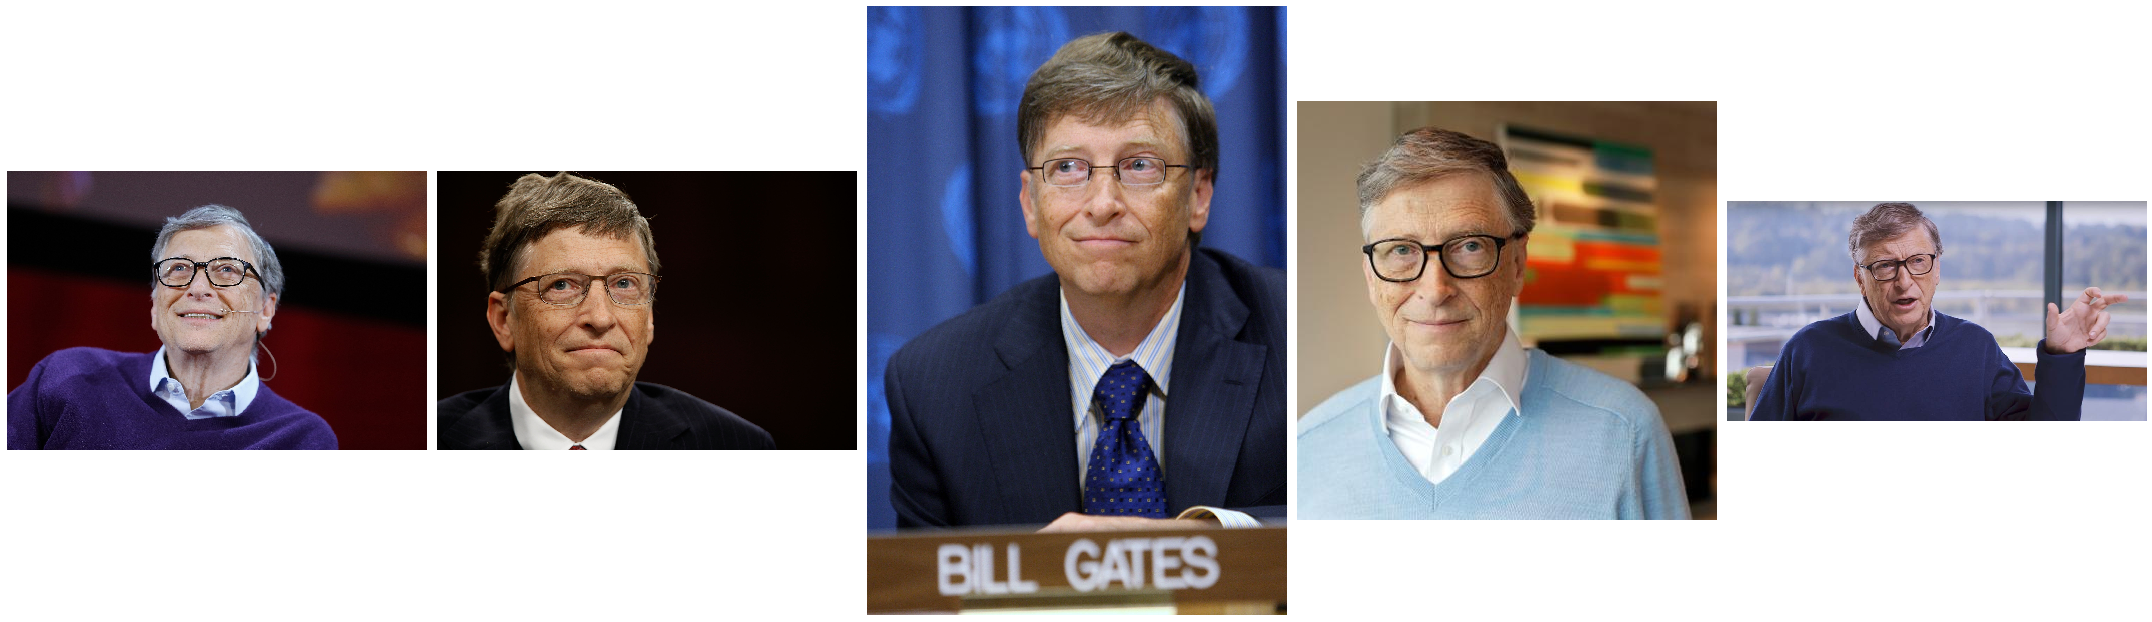

In [10]:
def display_images(l):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

display_images(images[:5])

In [11]:
print(ages)
age1 = 56
age2 = 60
print("Faces younger than {}: {}".format(age1,len([1 for x in ages if x<age1])))
print("Faces older than {}: {}".format(age2,len([1 for x in ages if x>=age2])))
print("Faces between: {}".format(len([1 for x in ages if (x<=age2) and (x>=age1)])))

[62.0, 56.0, 51.0, 62.0, 68.0, 53.0, 48.0, 61.0, 63.0, 33.0, 59.0, 64.0, 56.0, 62.0, 54.0, 55.0, 56.0, 58.0, 47.0, 41.0, 44.0, 58.0, 60.0, 55.0, 60.0, 64.0, 50.0, 69.0, 58.0, 56.0, 60.0, 53.0, 59.0, 64.0, 58.0, 62.0, 56.0, 39.0, 56.0, 61.0, 64.0, 50.0, 56.0]
Faces younger than 56: 14
Faces older than 60: 16
Faces between: 16


## Affine Transformations

The function to rotate our images to the fixes eyes-mouth position is defined below. We also pass a bool flag that determines if the picture should be part of left image or right image: 

In [13]:
import numpy as np

target1 = np.float32([(550.0,300.0),(300.0,500.0),(50.0,300.0)])
target2 = np.float32([(300.0,500.0),(800.0,500.0),(550.0,750.0)])
target3 = np.float32([(800.0,500.0),(550.0,300.0),(1050.0,300.0)])

def affine_transform(img,attrs,f):
    mc_x = (attrs['mouth_left']['x']+attrs['mouth_right']['x'])/2.0
    mc_y = (attrs['mouth_left']['y'] + attrs['mouth_right']['y']) / 2.0
    if f <= age1:
        tr = cv2.getAffineTransform(np.float32([(attrs['pupil_left']['x'],attrs['pupil_left']['y']),
                                            (attrs['pupil_right']['x'],attrs['pupil_right']['y']),
                                            (mc_x,mc_y)]), target1)
    elif f >= age2:
        tr = cv2.getAffineTransform(np.float32([(attrs['pupil_left']['x'],attrs['pupil_left']['y']),
                                            (attrs['pupil_right']['x'],attrs['pupil_right']['y']),
                                            (mc_x,mc_y)]), target3)
    else:
        tr = cv2.getAffineTransform(np.float32([(attrs['pupil_left']['x'],attrs['pupil_left']['y']),
                                            (attrs['pupil_right']['x'],attrs['pupil_right']['y']),
                                            (mc_x,mc_y)]), target2)
    return cv2.warpAffine(img,tr,(1100,900))

In [14]:
img_aligned = [ affine_transform(im,a,x) for im,a,x in zip(images,imagepoints,ages)]

## Image Blending

To blend images together, we just calculate the average:

In [16]:
def merge(imgs):
    return (np.average(np.array(imgs)/255.,axis=0)*255).astype(np.ubyte)

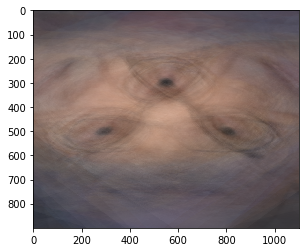

In [17]:
res = merge(img_aligned)
plt.imshow(res)

## Saving the result

I recommend to save the result into `results` directory, and to add quick description of the technique you used into `readme.md` file in the repo. To save the image, please execute the cell below:

In [19]:
cv2.imwrite('results/gates_is_mason.jpg',cv2.cvtColor(res,cv2.COLOR_BGR2RGB))

True

## Finally, we can see overwhelming evidence that Bill Gates is a freemason!!!
